In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
"""This module contains methods for dealing with MOER data."""
from __future__ import annotations

import calendar
from datetime import datetime, timedelta
from io import StringIO
import os
import pkgutil
import requests
from typing import Literal

import pandas as pd
import pytz

DEFAULT_DATE_RANGES = [
    ('2019-03-01', '2019-05-01'),
    ('2020-03-01', '2020-05-01'),
    ('2021-03-01', '2021-05-01'),
]

DATE_FORMAT = '%Y-%m-%d'

DataTypeStr = Literal['historical', 'forecasted']

USERNAME = 'caltech'
PASSWORD = 'caltechsgip.2022'
EMAIL = 'cyeh@caltech.edu'

LOGIN_URL = 'https://sgipsignal.com/login/'
DATA_URLS = {
    'historical': 'https://sgipsignal.com/sgipmoer/',
    'forecasted': 'https://sgipsignal.com/sgipforecast/'
}
DATA_VERSIONS = {
    'historical': '1.0',  # see API, vaild April 1, 2020 to January 31, 2022
    'forecasted': '1.0-1.0.0',
}
TIME_COLUMN = {
    'historical': 'point_time',
    'forecasted': 'generated_at',
}
MOER_COLUMN = {
    'historical': 'moer',
    'forecasted': 'forecast',
}

SGIP_DT_FORMAT = '%Y-%m-%dT%H:%M:%S'  # ISO 8601 timestamp

FNAME_FORMAT_STR = '{ba}_{year}-{month:02}.csv'
DEFAULT_SAVE_DIR = 'data'
COMPRESSION = 'gzip'
INDEX_NAME = 'time'

# BALANCING_AUTHORITIES = ['SGIP_CAISO_PGE', 'SGIP_CAISO_SCE',]
BALANCING_AUTHORITIES = ['SGIP_CAISO_SCE']

FIVEMINS = timedelta(seconds=300)
ONEDAY = timedelta(days=1)


def get_data_sgip(starttime: str, endtime: str, ba: str, req_type: DataTypeStr) -> pd.DataFrame:
    """Retrieves data from the SGIP Signal API.
    Authenticates user, performs API request, and returns data as a DataFrame.
    If type is 'historical', returns the historical marginal emissions rate.
    If type is 'forecast', returns the forecast for emissions rate at the next
    5 minute mark. See https://sgipsignal.com/api-documentation
    Args:
        starttime: start time for data. Format ISO 8601 timestamp.
            See https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations
        endtime: end time for data. See starttime.
        ba: balancing authority, responsible for region grid operation.
        req_type: either 'historical' or 'forecast'
    Returns:
        A single-column DataFrame containing either historical or forecasted
            rates with a DateTimeIndex labeled as time. The time index type
            is datetime64[ns, UTC] (in UTC time).
        If forecast:
            forecast                  float64
        If historical:
            moer                      float64
    Notes:
        Historical queries are limited to 31 days. Queries on forecasts
        are limited to 1 day.
    Examples:
        starttimestr = '2021-02-20T00:00:00'
        endtimestr = '2021-02-20T23:10:00'
        ba = 'SGIP_CAISO_PGE'
        df = get_data_sgip(starttimestr, endtimestr, ba, 'forecasted')
    """
    # Authenticate
    r = requests.get(LOGIN_URL, auth=(USERNAME, PASSWORD))
    token = r.json()['token']

    # Create API fields
    headers = {
        'Authorization': f'Bearer {token}'
    }
    params = dict(
        ba=ba,
        starttime=starttime,
        endtime=endtime,
        version=DATA_VERSIONS[req_type]
    )

    r = requests.get(DATA_URLS[req_type], params=params, headers=headers)
    df = pd.DataFrame(r.json())

    if req_type == 'forecasted':
        df['forecast'] = df['forecast'].map(lambda x: x[0]['value'])  # take next 5-min prediction
    
    time_column = TIME_COLUMN[req_type]
    moer_column = MOER_COLUMN[req_type]

    df = df.set_index(pd.DatetimeIndex(df[time_column], tz=pytz.UTC))
    df.index.name = INDEX_NAME
    return df[[moer_column]].copy()


def get_historical_and_forecasts(starttime: datetime, endtime: datetime, ba: str) -> pd.DataFrame:
    """Retrieves both forecasted and historical data.
    May request forecasted data repeatedly due to API constraints.
    See notes section in get_data_sgip for more info.
    Args:
        starttime: start time. A timezone-aware datetime object. If not
            timezone-aware, assumes UTC time.
        endtime: timezone-aware datetime object. See starttime.
        ba: balancing authority, responsible for region grid operation.
    Returns:
        A 2-column DataFrame containing both historical and forecasted
            rates with a DateTimeIndex labeled as time. The time index type
            is datetime64[ns, UTC] (in UTC time).
            forecast                  float64
            moer                      float64
    """
    # Localize datetimes to UTC.
    starttime = starttime.astimezone(pytz.UTC)
    endtime = endtime.astimezone(pytz.UTC)

    # Give one-day padding around starttime and endtime.
    starttime -= ONEDAY
    endtime += ONEDAY

    days30 = timedelta(days=30)
    days1 = ONEDAY

    combined_dfs = []
    for req_type in ['historical', 'forecasted']:
        # Go backwards so that there isn't need to sort
        # Set up request range
        span = days30 if req_type == 'historical' else days1
        req_endtime = endtime
        req_starttime = max(starttime, req_endtime - span + FIVEMINS)

        dfs = []
        while req_endtime >= starttime:
            # Retrieve data
            req_starttimestr = datetime.strftime(req_starttime, SGIP_DT_FORMAT)
            req_endtimestr = datetime.strftime(req_endtime, SGIP_DT_FORMAT)
            print(f"Retrieving {ba} {req_type}: {req_starttimestr}, {req_endtimestr}")
            df = get_data_sgip(req_starttimestr, req_endtimestr, ba, req_type)
            df.sort_index(axis=0, ascending=False, inplace=True)

            # Update request span
            req_endtime -= span
            req_starttime = max(starttime, req_endtime - span + FIVEMINS)

            if df.index[-1] == req_endtime:
                df.drop(df.tail(1).index, inplace=True)

            dfs.append(df)
        dfs = pd.concat(dfs, axis=0)
        combined_dfs.append(dfs)
    combined_dfs = pd.concat(combined_dfs, axis=1)
    return combined_dfs


def save_monthly_moer(year: int, month: int, ba: str, save_dir: str) -> None:
    """Saves month data.
    Saves month of forecasted and historical data from the balancing
    authority to a compressed csv file. May request forecasted data repeatedly
    due to API constraints. See notes section in get_data_sgip for more info. 
    Args:
        year: year of requested month
        month: requested month
        ba: balancing authority, responsible for region grid operation.
        save_dir: directory to save compressed csv to.
    """
    # Check whether data has already been saved
    file_name = FNAME_FORMAT_STR.format(ba=ba, year=year, month=month)
    save_path = os.path.join(save_dir, file_name)
    if os.path.exists(save_path):
        return

    os.makedirs(save_dir, exist_ok=True)  # Create directory as needed
    # Find range of dates for month and retrieve data
    num_days = calendar.monthrange(year, month)[1]
    starttime = datetime(year, month, 1, tzinfo=pytz.UTC)
    endtime = datetime(year, month, num_days, tzinfo=pytz.UTC)
    df = get_historical_and_forecasts(starttime, endtime, ba)
    df.to_csv(save_path, compression=COMPRESSION, index=True)  # keep datetime index


def save_moer(starttime: datetime, endtime: datetime, ba: str) -> None:
    """Saves all full-months data between a date range.
    Saves data separated by months as separate compressed csv files, which
    contain historical and forecasted marginal emission rates for the days
    spanning the month.
    Args:
        starttime: start time for data. Only year and month are used.
        endtime: end time for data. See starttime.
        ba: balancing authority, responsible for region grid operation.
    """
    if starttime > endtime:
        starttime, endtime = endtime, starttime
    syear, smonth = starttime.year, starttime.month
    eyear, emonth = endtime.year, endtime.month

    while (syear < eyear) or (syear == eyear and smonth <= emonth):
        save_monthly_moer(syear, smonth, ba, DEFAULT_SAVE_DIR)
        if smonth == 12:
            smonth = 1
            syear += 1
        else:
            smonth += 1


def save_moer_default_ranges():
    """Saves all monthly data for default date ranges.
    Repeatedly calls ``save_moer()`` for all months spanned by the default
    ranges. Saves for both balancing authorities: 'SGIP_CAISO_PGE',
    'SGIP_CAISO_SCE'.
    """
    for date_range_str in DEFAULT_DATE_RANGES:
        starttime = datetime.strptime(date_range_str[0], DATE_FORMAT)
        endtime =   datetime.strptime(date_range_str[1], DATE_FORMAT)
        for ba in BALANCING_AUTHORITIES:
            save_moer(starttime, endtime, ba)


def load_monthly_moer(year: int, month: int, ba: str, save_dir: str) -> pd.DataFrame:
    """Loads pandas DataFrame from file.
    Args:
        year: year of requested month
        month: requested month
        ba: balancing authority, responsible for region grid operation.
        save_dir: directory to save compressed csv to.
    Returns:
        A DataFrame of the emission rates for the month. See
        ``get_historical_and_forecasts()`` for more info.
    """
    # first search through custom models
    file_name = FNAME_FORMAT_STR.format(ba=ba, year=year, month=month)
    file_path = os.path.join(save_dir, file_name)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path,
                         compression=COMPRESSION,
                         index_col=INDEX_NAME)
    else:  # TODO check that this works
        MOER_DATA_MODULE = 'sustaingym.data'
        data = pkgutil.get_data(MOER_DATA_MODULE, file_path).decode('utf-8')
        data = StringIO(data)
        df = pd.read_csv(data, compression=COMPRESSION, index_col=INDEX_NAME)
    # TODO load in data from API using save_moer() if found in neither
    df.index = pd.to_datetime(pd.DatetimeIndex(df.index))  # set datetime index to UTC
    return df


def load_moer(starttime: datetime, endtime: datetime, ba: str, save_dir: str) -> pd.DataFrame:
    """Returns data for all months that overlap with interval.
    Args:
        starttime: start time for data. Only year and month are used.
        endtime: end time for data. See starttime.
        ba: balancing authority, responsible for region grid operation.
        save_dir: directory to load compressed csv from.
    Returns:
        A DataFrame of the emission rates for the all months of overlap. See
        ``get_historical_and_forecasts()`` for more info.
    
    Examples:
        starttime, endtime = datetime(2021, 2, 1), datetime(2021, 5, 31)
        ba = 'SGIP_CAISO_PGE'
        df = load_moer(starttime, endtime, ba, 'sustaingym/data/moer_data')
    """
    syear, smonth = starttime.year, starttime.month
    eyear, emonth = endtime.year, endtime.month

    dfs = []
    # Go backwards in time so order is descending
    while (syear < eyear) or (syear == eyear and smonth <= emonth):
        df = load_monthly_moer(eyear, emonth, ba, save_dir)
        if dfs:  # check for overlapping windows
            earliest_datetime = dfs[-1].tail(1).index[0]  # earliest time in previous window
            df = df[df.index < earliest_datetime]  # only fetch earlier window
        dfs.append(df)

        if emonth == 1:
            eyear -= 1
            emonth = 12
        else:
            emonth -= 1
    return pd.concat(dfs, axis=0)


class MOERLoader:
    """Class for loading emission rates data for gyms.
    Attributes:
        df: DataFrame of forecasted and historical data for date time range
    """
    def __init__(self, starttime: datetime, endtime: datetime, ba: str, save_dir: str):
        """
        Args:
            starttime: start time for data. Only year and month are used.
            endtime: end time for data. See starttime.
            ba: balancing authority, responsible for region grid operation.
            save_dir: directory to load compressed csv from.
        """
        self.df = load_moer(starttime, endtime, ba, save_dir)

    def retrieve(self, dt: datetime) -> pd.DataFrame:
        """Retrieves MOER data from attribute.
        Returns data starting at datetime for the next 24 hours. Assumes that
        dt is a timezone-aware datetime object.
        Args:
            dt: a timezone-aware datetime object. 
        Returns:
            A DataFrame of shape (289, 2). The first column is the historical
                MOER and the second the forecasted; both are in units 
                kg * CO2 per kWh. Note that the "rows" are backwards, in that
                the most recent rates are at the top, sorted descending.
        """
        dt_one_day_later = dt + ONEDAY + FIVEMINS
        return self.df[(dt <= self.df.index) & (self.df.index < dt_one_day_later)].values

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

save_moer_default_ranges()

Retrieving SGIP_CAISO_SCE historical: 2019-03-02T00:05:00, 2019-04-01T00:00:00
Retrieving SGIP_CAISO_SCE historical: 2019-02-28T00:00:00, 2019-03-02T00:00:00
Retrieving SGIP_CAISO_SCE forecasted: 2019-03-31T00:05:00, 2019-04-01T00:00:00
Retrieving SGIP_CAISO_SCE forecasted: 2019-03-30T00:05:00, 2019-03-31T00:00:00


ValueError: If using all scalar values, you must pass an index

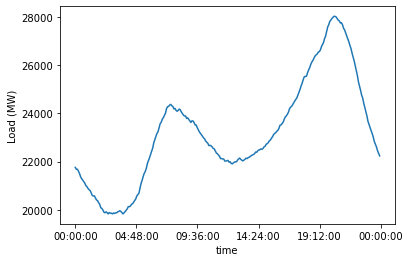

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as plticker

fmt = mdates.DateFormatter('%H:%M:%S')

df_load = pd.read_csv('data/CAISO-netdemand-2019-05.csv', nrows=1)

time_arr = df_load.columns[1:-1]
time_arr = [t + ':00.0' for t in time_arr]
timeArray = [datetime.datetime.strptime(i, '%H:%M:%S.%f') for i in time_arr]

x = np.array(df_load.iloc[0,1:-1])

fig, ax = plt.subplots()

ax.plot(timeArray, x)

# naming the x axis 
plt.xlabel('time') 
# naming the y axis 
plt.ylabel('Load (MW)')

ax.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

fmt = mdates.DateFormatter('%H:%M:%S')

df_moer = pd.read_csv('data/SGIP_CAISO_SCE_2019_05.csv')

x = np.array(df_moer.iloc[288:288*2, 1])

fig, ax = plt.subplots()

ax.plot(timeArray, x)

# naming the x axis 
plt.xlabel('time') 
# naming the y axis 
plt.ylabel('MOER (mT CO2/MWh)')

ax.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

FileNotFoundError: [Errno 2] No such file or directory: 'data/SGIP_CAISO_SCE_2019_05.csv'

In [2]:
import pandas as pd
import numpy as np

df_moer = pd.read_csv('data/SGIP_CAISO_SCE_2019_05.csv')

x = np.array(df_moer.iloc[288:288*2, 0])

print(len(x))

288
